# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

### **Semana 6**
#### **Máquina de Vector Soporte - Support Vector Machine (SVM)**

### El método de máquina de vector soporte (SVM) es válido para problemas tanto de clasificación como de regresión.

### En realidad este método involucra varios modelos dentro del concepto de SVMs, a saber, los modelos lineales y los radiales.

### En particular podemos hacer uso de scikit-learn para la implementación de cualquier tipo de problema, clasificación o regresión:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [1]:
import sklearn
from sklearn import datasets
from sklearn import svm

#from sklearn import metrics


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Parte 1 : Máquina de Vector Soporte (SVM)**

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

Veremos en este Jupyter-Notebook una aproximación geométrica de las SVM que nos permitan entender mejor la manera en que funcionan.

Para ello simularemos una problema de clasificación:

In [21]:
data = sklearn.datasets.make_blobs(n_samples=1000,             # número de datos a generar.
                                   n_features=2,               # número de factores.
                                   centers=[(-4,-4),(4,4)],    # coordenadas de los centros de las dos clases a generar.
                                   cluster_std=2.,            # desviación estándar de cada cúmulo generado.
                                   random_state=10)

In [22]:
X, y = data
#y = y.reshape(y.shape[0],1)

print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


###El arreglo X está definido por un conjunto de puntos en el plano dimensional 2D, donde cada uno de esos datos está asociado a una de dos clases: el conjunto de observaciones de la clase del 0 centrada en el punto (-4,-4) y el conjunto de observaciones de la clase del 1 centrada en el punto (4,4).

Visualicemos dichos registros y observemos que son linealmente separables.

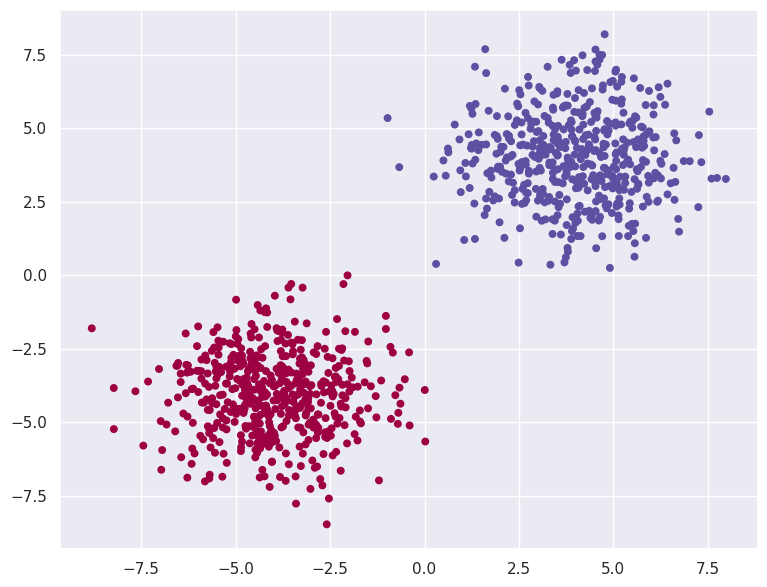

In [18]:
sns.set(rc={'figure.figsize':(9,7)})   # (width, height) - definiendo el tamaño del canvas.
plt.scatter(X[:,0], X[:,1], c=y, s=22, cmap=plt.cm.Spectral);

In [ ]:
print(X[0:5,:])     # podemos observar las coordenadas de las primeras 5 observaciones

[[ 4.52703933  2.91738139]
 [ 4.39524952  3.50592185]
 [-3.01340218 -3.97177263]
 [-4.19410253 -5.74673584]
 [ 3.23864646  4.05911423]]


In [ ]:
print(y[0:5])    # y las etiquetas de estas 5 observaciones.

[1 1 0 0 1]


## **1.1 : Modelo Lineal - Hiperplano Separador : Conjuntos linealmente separables**

Observa que en el siguiente diagrama se estarán dibujando dos hiperplanos separadores, además de sus regiones dada por los márgenes máximos. Es decir, lo podemos ver como la región con respecto al hiperplano que se expande de forma simétrica hasta que uno de los extremos alcance por primera vez a un punto de alguna de las dos clases.

Observa que ninguno de los dos hiperplanos (rectas) son de margen máximo, es decir, no están centrados y solo uno de los extremos de cada margen alcanza solo a un punto de una de las dos clases.

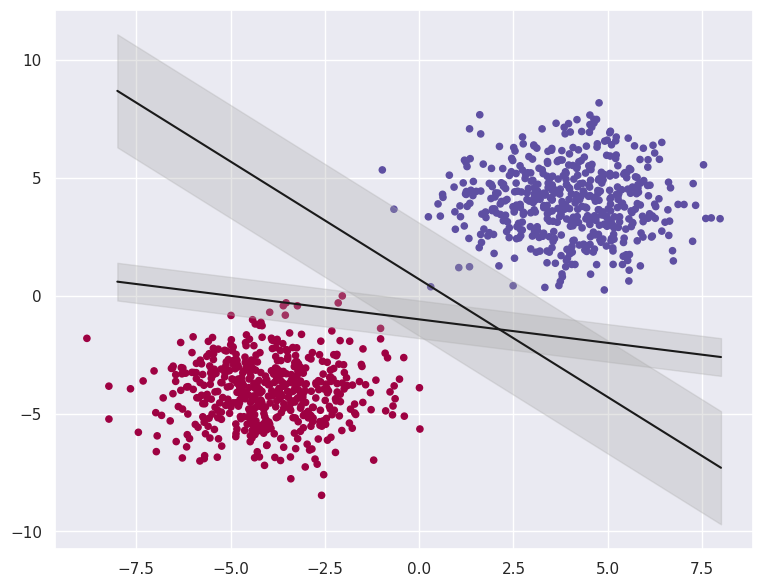

In [19]:
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=plt.cm.Spectral);  # Gráfico de dispersión de ambas clases

# Y dibujamos dos hiperplanos-clasificadores lineales, con sus márgenes de separación.
# Estos dos hiperplanos son arbitrario y solo para fines ilustrativos.
xhs = np.linspace(-8, 8,)   # generamos un conjunto de 50 puntos entre -8 y 8.
for m, b, d in [(-1, 0.7, 2.4),  (-0.2, -1, 0.8)]:      # (m,b,d) --> m: pendientes  /  b: ordenadas en el origen   /  d: margen máximo
    yhs = m * xhs + b
    plt.plot(xhs, yhs, '-k');
    plt.fill_between(xhs, yhs - d, yhs + d, edgecolor='none',color='#AAAAAA', alpha=0.3);  # márgenes máximos de cada HiperplanoSeparador


###**gráfico de los vectores de soporte con sus hiperplanos de margen máximo:**


In [9]:
# Definimos una función para visualizar los hiperplanos separadores e identicar los vectores de soporte.
# Esto es para fines ilustrativos del ejemplo, pero que nos ayudará a entender mejor la manera que el
# modelo SVM funciona, así como algunos de sus principales hiperparámetros.

def plot_svc_decision_function(model,
                               ax=None,
                               plot_support=True     # para indicar si quieres resaltar los vecotres de soporte
                               ):

    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()   # intervalo (puntos máximo y mínimo) en el cual varían todos los registros.
    ylim = ax.get_ylim()


    # generemos nuestro grid de valores en los cuales estaremos evaluando:
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)

    xy = np.vstack([X.ravel(), Y.ravel()]).T    # ravel convierte cada uno a 1-D.

    P = model.decision_function(xy).reshape(X.shape)  # "decision_function" genera predicciones sobre a qué clase asigna cada punto del grid.

    # dibuja el hiperplano y sus fonteras de margen máximo
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '-.'])    # para distinguir entre cada hiperplano


    # resaltemos de amarillo los vectores de soporte:
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=400, facecolors='yellow', alpha=0.3);    # coloreamos de amarillo cada vector de soporte.
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


###**Kernel Lineal : Hiperplano Separador Máximo - Caso linealmente separable**

Uno de sus principales parámetros es el de regularización C, que está asociado a la regularización ridge con la métrica $L_2$.

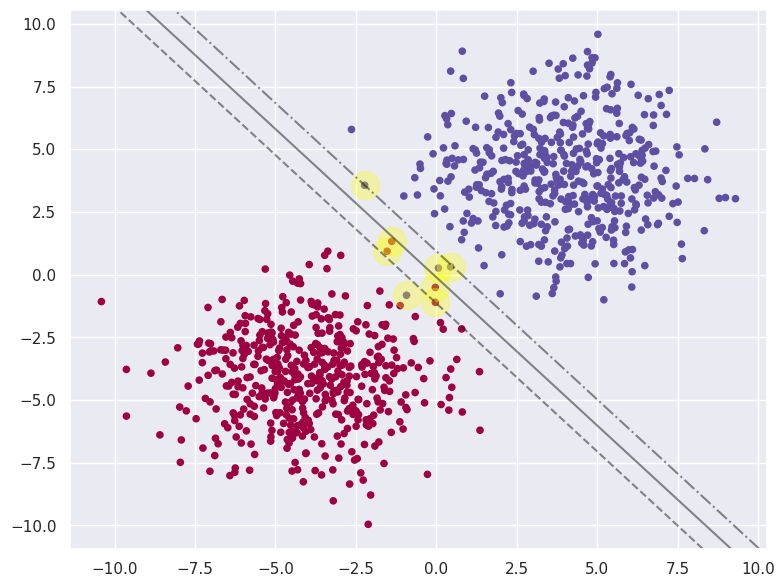

In [29]:
# Parámetro de regularización C
# A medida que disminuye C, la región de separación aumenta y datos de ambas clases quedan dentro de dicha región.
# Esto permitiría mayor tolerancia al ruido por parte del modelo.
# Por otro lado, mayor valor de C, más angosta la región de separación, o hasta donde haya datos de cada clase.

model = svm.SVC(kernel='linear',    # usando el kernel lineal
                C=1    # C=1000, 1, 0.1, 0.01         # Parámetro de regularización L2.
                )                                    # Más pequeño el valor de C, más ancho el margen de separación,
                                                     # aunque algunos puntos ya queden dentro del margen de separación.


model.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plot_svc_decision_function(model);

El objetivo durante el entrenamiento de la SVM es encontrar sus "pesos", que en este caso son los vectores de soporte.

In [ ]:
# Estos son los vectores de soporte encontrados del modelo y lo que se usará para hacer posteriormente las clasificaciones.
# Observa que los tres puntos amarillos son los llamados vectores de soporte y están dadas por las siguientes coordenadas;

model.support_vectors_

array([[-2.69151285, -1.33742253],
       [-2.01491541, -2.25518585],
       [ 1.53777742,  1.58876843]])

In [ ]:
model.support_    # y de requerirse, estos son los índices de los vectores de soporte.

array([205, 680, 850], dtype=int32)

## **1.2 : Kernel Radial o función de base radial (RBF-radial basis function) : Conjuntos separables linealmente**

#### **Parámetros C (regularización) y gamma (radio de influencia de los vectores de soporte)**

Los modelos radiales involucran dos parámetros, usualmente llamados C y gamma.

El parámetro C sigue siendo el de regularización con la métrica $L_2$.

Gamma es un parámetro usualmente llamado el parámetro del Kernel. Está asociado con el radio de influenca de los vectores de soporte. Dicha influencia varía de manera inversa al radio de la distancia.

De manera genérica se puede iniciar la búsqueda de C y gamma entre $10^{-5}$ y $10^5$. Si el mejor valor resulta en uno de estos extremos, se puede realizar una nueva búsqueda alrededor de dichos valores. También se puede usar la función np.logspace() para generar un conjunto de valores en potencias de 10.

Ver la documentación del scikit-learn para mayor información:

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Por ser C el término de regularización $L_2$, a medida que C aumenta se castiga más al modelo en cuanto que se disminuye la cantidad de vectores de soporte. Y a medida que disminuye C, se permite una mayor cantidad de vectores de soporte, por lo que se debe cuidar el problema del sobreentrenamiento.

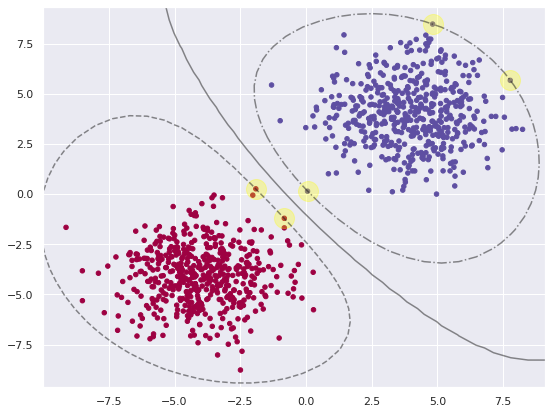

In [ ]:
# Ejemplos de SVM-RBF con Gamma constante y haciendo variar C:

N=1000
noisy_data = sklearn.datasets.make_blobs(n_samples=N, n_features=2, centers=[(-4,-4),(4,4)], cluster_std=1.6, random_state=10)
X, y = noisy_data

# A medida que disminuye C, podríamos decir que "se contrae" la frontera de vectores de soporte y generalmente aumentan,
# ya que se introduce en una región más densa de observaciones.
# Aunque para el caso de clases seprables siguen quedando bien clasificados.
# Así, como al disminuir el valor de C se incrementa el número de vectores de soporte,
# se hace más costoso el tiempo de ejecución del modelo.

model = svm.SVC(kernel='rbf', C=100.)       # intentar estos valores de C=100, 10, 1, 0.5, 0.1, .01
                                            # gamma=default (fijo),
model.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plot_svc_decision_function(model);

Se puede usar la función "logspace" o "linspace" para generar un conjunto de valores entre dos vlores dados.

Por ejemplo, estos ejemplos generan 7 puntos igualmente espaciados:

np.linspace(-3, 3, 7), los genera entre -3 y 3.

np.logspace(-3, 3, 7)   los genera como potencias de 10, i.e., entre $10^{-3}$ y $10^{+3}$.

Esto se combina usualmente con las funciones GridSearch para la búsqueda del mejor valor durante el entrenamiento de una SVM.

El valor predeterminado de gamma es inversamente proporcional a la varianza de los datos de entrenamiento.

## **1.3 : SVM - RBF : Conjuntos separables, pero no linealmente**

In [ ]:
1/(2*X.var())   # gamma default

0.027151867071410846

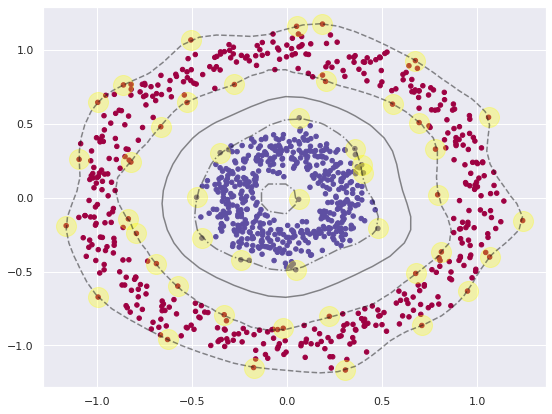

In [ ]:
# Ejemplos de SVM-RBF con  C constante, y ahora hacemos variar gamma (radio de influencia):

N=1000
noisy_data = sklearn.datasets.make_circles(n_samples=N,
                                           factor = 0.3,   # factor de separación entre los círculos
                                           noise=0.08,
                                           random_state=10)

X, y = noisy_data

# En este caso de conjuntos separables radialmente.
# A medida que gamma se hace más grande (con C constante) más irregulares las fronteras separadoras y se va generando overfitting.
# Es decir, gamma más grandes significa radio de influencia más pequeña o cercana y por ello más irregular.
# Cuando se habla de "radio" en realidad es el "radio de curvatura de la frontera en cada vector de soporte.
# Radios pequeños (gamma pequeño) equivale a mayor irregularidad.

model = svm.SVC(kernel='rbf',
                C=10,       # mantengamos C con este valor constante, fijo.
                gamma=10      # Ahora intentar estos valores de gamma= .05, 0.1, 1, 10, 30, 50
                )
model.fit(X, np.ravel(y))

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plot_svc_decision_function(model);

## **1.4: SVM - RBF Caso: conjuntos linealmente no-Separables:**

Hay casos donde desde un inicio no existe un hiperplano separador.

Aquí entra el concepto de las variables de holgura.

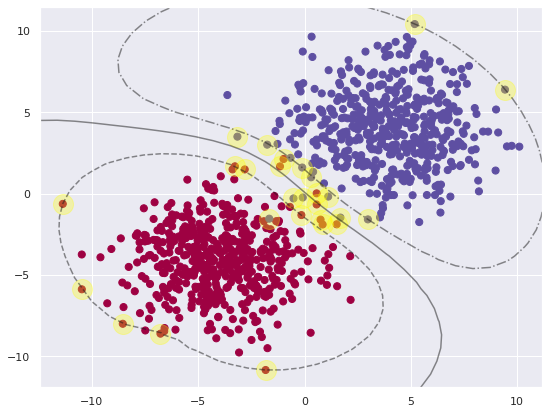

In [ ]:
N=1000
noisy_data2 = sklearn.datasets.make_blobs(n_samples=N, n_features=2, centers=[(-4,-4),(4,4)], cluster_std=2.3, random_state=10)

X2, Y2 = noisy_data2


# En el caso lineal, por más grande que sea el valor de C, ya hay puntos que están mal clasificados y no se modifican las fornteras.
# En el caso radial sí se podrían ir ajustando, aunque hay que cuidar el overfitting:

C =  10

modelnol = svm.SVC(kernel='rbf', C=C, gamma=0.03)     # intenta con kernel lineal y radial y varios casos de C y gamma
                                                     # Recuerda que gammas muy grandes pueden llevar al sobreentrenamiento.
modelnol.fit(X2, Y2)

plt.scatter(X2[:, 0], X2[:, 1], c=Y2, s=50, cmap=plt.cm.Spectral)
plot_svc_decision_function(modelnol)

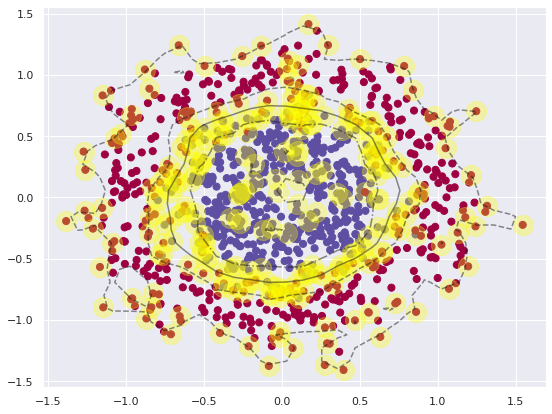

In [ ]:
# En el caso lineal, por más grande que sea el valor de C, ya hay puntos que están mal clasificados y no se modifican las fornteras.
# En el caso radial sí se podrían ir ajustando, aunque hay que cuidar el overfitting:

N=1000
noisy_data = sklearn.datasets.make_circles(n_samples=N,
                                           factor = 0.4,   # factor de separación entre los círculos
                                           noise=0.18,
                                           random_state=10)

X2, Y2 = noisy_data


C =  1
g = 20

modelnol = svm.SVC(kernel='rbf', C=C, gamma=g)     # intenta con kernel lineal y radial y varios casos de C y gamma
                                                     # Recuerda que gammas muy grandes pueden llevar al sobreentrenamiento.
modelnol.fit(X2, Y2)

plt.scatter(X2[:, 0], X2[:, 1], c=Y2, s=50, cmap=plt.cm.Spectral)
plot_svc_decision_function(modelnol)

# **Parte - 2: Curva ROC**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

0.88


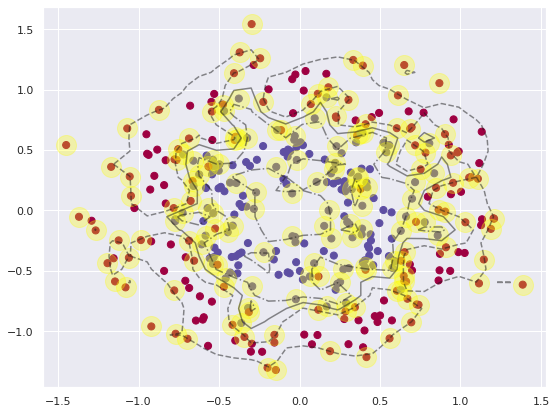

In [ ]:
noisy_data = sklearn.datasets.make_circles(n_samples=500, factor=0.5,  noise=0.2, random_state=10)
X3, y3 = noisy_data
Xtrain, Xtest, ytrain, ytest = train_test_split(X3, y3, test_size=.3, shuffle=True, random_state=1)

modeloSVM = svm.SVC(kernel='rbf', C=10, gamma=35)

modeloSVM.fit(Xtrain, ytrain)

print(modeloSVM.score(Xtest, ytest))

plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap=plt.cm.Spectral)
plot_svc_decision_function(modeloSVM)


Si utilizas la curva ROC para ajustes de hiperparámetros de algún modelo, debes de usar el conjunto de validación.

Si utilizas la curva ROC para la evaluación final del modelo, debes usar el conjunto de prueba (test).

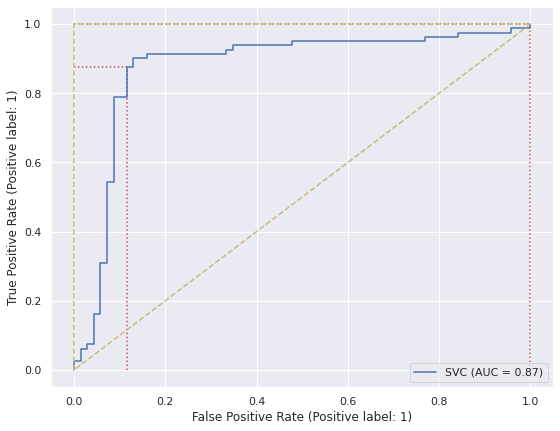

In [ ]:
# Obtenemos las predicciones del modelo:
yhat = modeloSVM.predict(Xtest)

# Obtenemos la tasa de falsos positivos (fpr) y la tasa de verdaderos positivos (tpr):
fpr, tpr, _ = metrics.roc_curve(ytest, yhat)


metrics.RocCurveDisplay.from_estimator(modeloSVM, Xtest, ytest)

plt.plot([0,0,1,0],[0,1,1,0], 'y--')

plt.hlines(tpr, 0, fpr, colors='r', linestyles='dotted')  # Se calcula TPrate y FPrate con base a threshold=0.5
plt.vlines(fpr, 0, tpr, colors='r', linestyles='dotted')  # como valor predeteminado
plt.show()

### **La curva ROC ayuda también a comparar el desempeño de diferentes modelos**

In [ ]:
modeloLR = LogisticRegression(max_iter=1000, C=.01).fit(Xtrain, ytrain)
modeloLR.score(Xtest, ytest)

0.46

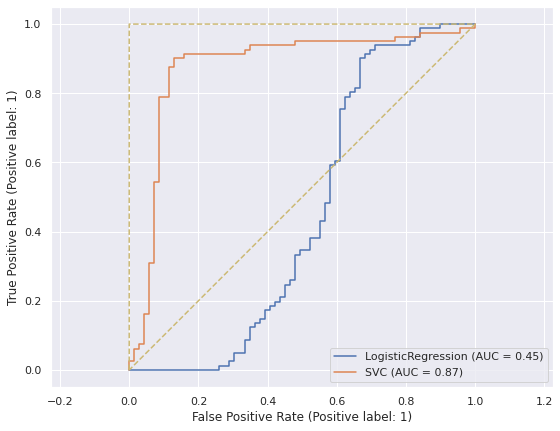

In [ ]:
lr_curve = metrics.RocCurveDisplay.from_estimator(modeloLR, Xtest, ytest)
svm_curve = metrics.RocCurveDisplay.from_estimator(modeloSVM, Xtest, ytest, ax=lr_curve.ax_)

plt.plot([0,0,1,0],[0,1,1,0], 'y--')


plt.axis('equal')
plt.show()

Vemos que el modelo de Regresión Logística está en gran parte por debajo del modelo completamente aleatorio. Aunque ya se veía el mal desempeño con el resultado del modelo logístico bastante pobre.

###**Fin del Jupyter-Notebook de la semana 8 (SVM)**